In [1]:
# add quantkit to path
import sys
from pathlib import Path
d = Path().resolve().parent.parent.parent
sys.path.insert(0, str(d))

In [2]:
import quantkit.bt as bt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### YFinance

In [3]:
pip install yfinance==0.2.36

Note: you may need to restart the kernel to use updated packages.


In [35]:
import yfinance as yf
import matplotlib.pyplot as plt

names = ["AAPL", "TSLA"]
wts = [0.5, 0.5]
df_yf = yf.download(names, start='2018-01-01', end='2023-01-01', progress=False)["Adj Close"]
df_yf = df_yf.filter(names)

df_yf.head()

/usr/local/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/usr/local/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,AAPL,TSLA
Date,,
2018-01-02,40.670975,21.368668
2018-01-03,40.663895,21.150000
2018-01-04,40.852776,20.974667
2018-01-05,41.317894,21.105333
2018-01-08,41.164433,22.427334


In [34]:
# return
ret_data = df_yf.pct_change()[1:]
df_ret = (ret_data * wts).sum(axis=1)
df_ret = df_ret.to_frame()
df_ret.rename(columns={0: 'return'}, inplace=True)
df_ret.head()

,return
Date,
2018-01-03,-0.005204
2018-01-04,-0.001823
2018-01-05,0.008807
2018-01-08,0.029462
2018-01-09,-0.004100


In [31]:
# cumulative return
df_cret = (df_ret + 1).cumprod()
df_cret.rename(columns={'return': 'cumulative return'}, inplace=True)

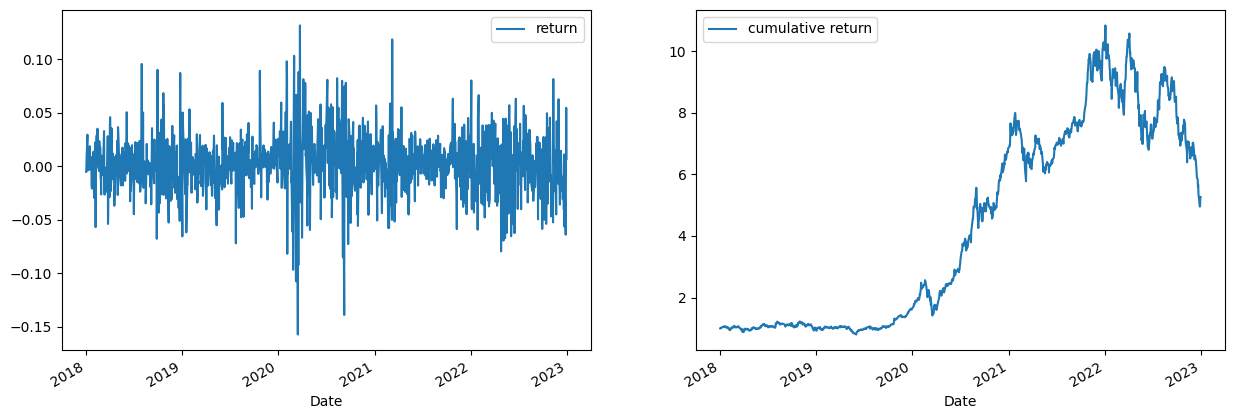

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df_ret.plot(ax=axes[0], figsize=(15, 5))
df_cret.plot(ax=axes[1], figsize=(15, 5))

plt.show()

### Quandl price data

In [10]:
import quantkit.handyman.quandl_data_loader as quandl_data_loader     
import quantkit.core.data_sources.quandl as quandl
import importlib
importlib.reload(quandl_data_loader)
importlib.reload(quandl)

names = ["AAPL", "TSLA"]

df = quandl_data_loader.get_price_data(
    names,
    start_date="2018-01-01",
    end_date="2023-01-01"    
)

df.head()

2024-05-09 21:27:22,303  WORKING ON: Batch 1/1


,ticker,date,open,high,low,close,volume,closeadj,closeunadj,lastupdated
0,AAPL,2018-01-02,42.540,43.075,42.315,43.065,102223736.0,40.670,172.26,2024-02-09
1,AAPL,2018-01-03,43.133,43.638,42.990,43.057,118071596.0,40.663,172.23,2024-02-09
2,AAPL,2018-01-04,43.135,43.367,43.020,43.258,89738388.0,40.852,173.03,2024-02-09
3,AAPL,2018-01-05,43.360,43.843,43.263,43.750,94640072.0,41.317,175.00,2024-02-09
4,AAPL,2018-01-08,43.587,43.903,43.483,43.587,82271064.0,41.164,174.35,2024-02-09


In [ ]:
df['ticker']

In [16]:
df['1D'] = ((df['close']/df.groupby('ticker')['close'].shift()-1) * 100).round(2)
df.head()

,ticker,date,open,high,low,close,volume,closeadj,closeunadj,lastupdated,1D
0,AAPL,2018-01-02,42.540,43.075,42.315,43.065,102223736.0,40.670,172.26,2024-02-09,NaN
1,AAPL,2018-01-03,43.133,43.638,42.990,43.057,118071596.0,40.663,172.23,2024-02-09,-0.02
2,AAPL,2018-01-04,43.135,43.367,43.020,43.258,89738388.0,40.852,173.03,2024-02-09,0.47
3,AAPL,2018-01-05,43.360,43.843,43.263,43.750,94640072.0,41.317,175.00,2024-02-09,1.14
4,AAPL,2018-01-08,43.587,43.903,43.483,43.587,82271064.0,41.164,174.35,2024-02-09,-0.37


In [27]:
df.set_index('date').iloc[1:]['1D']

date
2018-01-03    -0.02
2018-01-04     0.47
2018-01-05     1.14
2018-01-08    -0.37
2018-01-09    -0.01
              ...  
2022-12-23    -1.76
2022-12-27   -11.41
2022-12-28     3.31
2022-12-29     8.08
2022-12-30     1.12
Name: 1D, Length: 2517, dtype: float64

In [32]:
df.set_index('date').iloc[1:]['1D']

date
2018-01-03    -0.02
2018-01-04     0.47
2018-01-05     1.14
2018-01-08    -0.37
2018-01-09    -0.01
              ...  
2022-12-23    -1.76
2022-12-27   -11.41
2022-12-28     3.31
2022-12-29     8.08
2022-12-30     1.12
Name: 1D, Length: 2517, dtype: float64

In [33]:
df.set_index('date').iloc[1:]['1D'].isnull().values.any()

True

In [53]:
pd.DataFrame([[1,2], [8, 7]], columns=['a', 'b']).sum(axis=1)

0     3
1    15
dtype: int64

<Axes: xlabel='date'>

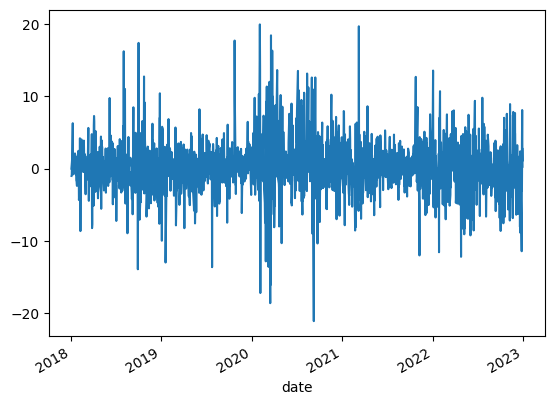

In [47]:
(df.set_index('date').iloc[1:]['1D']).plot()

In [46]:
(df.set_index('date').iloc[1:]['1D']).cumprod(skipna=True)

date
2018-01-03   -0.020000
2018-01-04   -0.009400
2018-01-05   -0.010716
2018-01-08    0.003965
2018-01-09   -0.000040
                ...   
2022-12-23    0.000000
2022-12-27   -0.000000
2022-12-28   -0.000000
2022-12-29   -0.000000
2022-12-30   -0.000000
Name: 1D, Length: 2517, dtype: float64

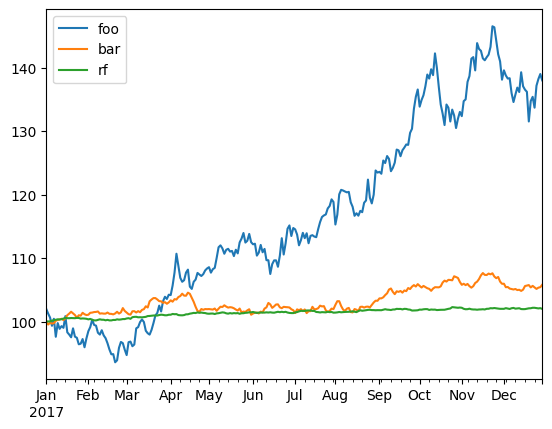

In [17]:
names = ["foo", "bar", "rf"]
dates = pd.date_range(
    start="2017-01-01", end="2017-12-31", freq=pd.tseries.offsets.BDay()
)
n = len(dates)
rdf = pd.DataFrame(np.zeros((n, len(names))), index=dates, columns=names)

np.random.seed(1)
rdf["foo"] = np.random.normal(loc=0.1 / n, scale=0.2 / np.sqrt(n), size=n)
rdf["bar"] = np.random.normal(loc=0.04 / n, scale=0.05 / np.sqrt(n), size=n)
rdf["rf"] = np.random.normal(loc=0.02 / n, scale=0.01 / np.sqrt(n), size=n)

pdf = 100 * np.cumprod(1 + rdf)
pdf.plot();

In [8]:
children = [ bt.Security( name ) for name in pdf.columns ]